# Hybrid Vision Transformer (ViT) vs standard ViT for CIFAR100 image classification

## Prerequisites
1. Linux OS
2. Conda Environment installed according to the steps from https://github.com/pgagarinov/pytorch-hyperlight/blob/main/products/jupyterlab-ml-devenv/README.md
3. PyTorch-Hyperlight package `pip install pytorch-hyperlight`

In [1]:
import os
import logging
import warnings
from pathlib import Path
from git import Repo
import pytorch_hyperlight as pth
import torch
from pytorch_hyperlight.datasets.cifar import CIFARDataLoadersBuilder
from pytorch_hyperlight.tasks.classification import (
    AAutoClsHeadClassificationTaskWDAdamWStepLR,
)
import numpy as np
from pytorch_hyperlight.utils.request_utils import copy_urls_to_files
import torch.nn as nn

In [2]:
FAST_DEV_RUN = False  # if true, simplifed configurations running for just a few epochs are used for making sure there are no obvious bugs

## Loading data from UTKFace dataset

Let us look at the data after all the data augmentation transformations

In [3]:
EXPERIMENT_ID = "vit-utk-faces"

In [4]:
SEED = 16

In [5]:
if "workbookDir" not in globals():
    workbookDir = os.getcwd()
WORKBOOK_DIR = Path(workbookDir)

The original images in CIFAR100 dataset have resolution of 32 x 32 pixels. Since hybrid ViT and standard ViT are designed to work with much higher resolution images we cannot feed CIFAR100 to the models direction. Instaead we will upscale the images up to 224 x 224 resolution via bilinear interpolation. 

Also, instead of using CIFAR100 dataset from Torchvision directly we will use the data loaders builder CIFARDataLoadersBuilder class from PyTorch-Hyperlight. The data augmentation (as well as image resolution upscaling) is already integrated into the builder class so that the output iamges has the resolution expected by ViT

In [6]:
IMAGE_SIZE = 224

CIFARDataLoadersBuilder returns two functions: f_create_dataloaders and f_create_datasets
 - f_create_dataloaders has `batch_size` as a single obligatory argument and returns a dictionary of both datasets and data loaders for training, validation and testing. 
 - f_create_datasets has no obligatory input arguments and returns a set of datasets for training, validation and testing.
 

Both f_create_datasets and f_create_dataloaders accept `val_size` optional keyword argument that defines a portion of training CIFAR100 dataset allocated for validation. The default value is 0.2 (20%).
Since 20% is allocated for validation the training dataset will only contain 80% of the original CIFAR100 dataset. Because of that the model performance may drop a little bit (comparing to using the whole CIFAR100 training dataset for training)

In [7]:
f_create_dataloaders, f_create_datasets = CIFARDataLoadersBuilder(
    seed=SEED,
    root_path=WORKBOOK_DIR / "_datasets",
    image_size=IMAGE_SIZE,
    dataset_name='cifar100'
).build()

In [8]:
warnings.filterwarnings("ignore")

In [9]:
BATCH_SIZE = 32
loaders_dict = f_create_dataloaders(BATCH_SIZE)
batch = next(iter(loaders_dict["test_loader"]))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Let us look at both datasets and dataloaders inside `loaders_dict` dictionary returned by by `f_create_dataloaders` function:

In [10]:
loaders_dict

{'train_full_augmented_dataset': Dataset CIFAR100
     Number of datapoints: 50000
     Root location: /home/peter/_Git/_ML/_DLSchool/pytorch-hyperlight/products/examples/image_classification/_datasets/cifar100
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.05, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 'train_full_dataset': Dataset CIFAR100
     Number of datapoints: 50000
     Root location: /home/peter/_Git/_ML/_DLSchool/pytorch-hyperlight/products/examples/image_classification/_datasets/cifar100
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 'train_augmented_dataset': <torch.utils.d

In [11]:
assert len(batch[0]) > 0

In [12]:
assert all([x == IMAGE_SIZE for x in batch[0][0].shape[1:]])

### Standard Vision Transformer vs Hybrid Vision Transformer

In this notebook we will use vision transformers from [ViT-pytorch](https://github.com/jeonsworld/ViT-pytorch) Github repository because this repository contains implementation for both standard ViT and hybrid ViT. For standard ViT we use the smallest "ViT-B_16" transformer and the smallest hybrid "R50+ViT-B_16" ViT. Both transformers are initialized with [Google's ViT weights pretrained on ImageNet21k](https://console.cloud.google.com/storage/browser/vit_models/imagenet21k).

We'll use a double-layered FC classification head with biases initialized with zeros to make sure we do not introduce any unnecessary bias to the transformers heads. Dropout between the layeres should help with overfitting.

Since we will compare Vision Transformers under the same settings we can safely use the same metrics calculation logic, criterions and optimizers. All this is mostly implemented in a reusable `AAutoClsHeadClassificationTaskAdamStepLR` class imported from PyTorch-Hyperlight. 

In [13]:
N_CLASSES = loaders_dict["n_classes"]
IS_CUDA = torch.cuda.is_available()
GPU_PER_TRIAL = 0.3 * IS_CUDA

We use batch size = 14 for both compared models. This is a limitation imposed by using RTX 2070 8Gb GPU with 16bit precision and training two transformers one by one inside the same Jupyter notebook.

In [14]:
CONFIG = {
    "classifier_lr": 1e-3,
    "rest_lr": 4e-5,
    "step_lr_gamma": 0.7,
    "step_lr_step_size": 1,
    "classifier_dropout": 0.2,
    "gradient_clip_val": 0,
    "max_epochs": 20,  # the actual number can be less due to early stopping
    "batch_size": 14,
    "no_weight_decay_param_names": ["bias", "LayerNorm.weight"],
    "weight_decay": 0,
    "n_classes": N_CLASSES,
}

EXTRA_CONFIG = {
    "seed": SEED,  # just remove this if you do not want determenistic behavior
    "metric_to_optimize": "val_f1_epoch",  # Ray + PTL Trainer
    "ray_metrics_to_show": [
        "val_loss_epoch",
        "val_f1_epoch",
        "val_acc_epoch",
    ],  # for Ray Tune
    "metric_opt_mode": "max",  # Ray + PTL Trainer
    "cpu_per_trial": 3,  # Ray + DataLoaders
    "gpu_per_trial": GPU_PER_TRIAL,  # for Ray Tune
    "n_checkpoints_to_keep": 1,  # for Ray Tune
    "grace_period": 0,  # for both PTL Trainer and Ray Tune scheduler
    "epoch_upper_limit": 45,  # for Ray Tune
    "n_samples": 3,  # for Ray Tune
    "ptl_early_stopping_patience": 3,  # for PTL Trainer
    "ptl_precision": 16,  # or 16, for PTL Trainer
    "train_loader_name": "train_augmented_loader",
    "val_loader_name": "val_loader",
    "test_loader_name": "test_loader",
    "batch_size_main": CONFIG[
        "batch_size"
    ],  # batch size for revalidation and test phases
    #    that run in the main process after all Ray Tune child processes are finished
    "gpus": -1 * IS_CUDA,  # -1 - use GPU if available, 0 - use CPU, 1 - use single GPU,
    # >=2 - use multiple GPUs
}

if FAST_DEV_RUN:
    CONFIG["max_epochs"] = 2
    EXTRA_CONFIG["n_samples"] = 2

The `Runner` class from PyTorch-Hyperlight hides all the technicalities related to training, validation and testing of the model. 

In [15]:
runner = pth.Runner(
    f_create_dataloaders,
    is_debug=FAST_DEV_RUN,
    experiment_id=EXPERIMENT_ID,
    log2wandb=False,
)

We will use `run_single_trial` method of `Runner` to run a single `trial` i.e a single cycle of training-validation-testing. Please note that we do not pass an instance of our PyTorch-Lightning module into `Runner`. Instead we just pass a class name of our model and let `Runner` instantiate the module by itself.

### Cloning ViT-Pytorch Github repo

In [16]:
VIT_PYTORCH_GIT_REPO_URL = "https://github.com/jeonsworld/ViT-pytorch"

In [17]:
VIT_PYTORCH_REPO_DIR = WORKBOOK_DIR / "ViT-pytorch"

In [18]:
if not VIT_PYTORCH_REPO_DIR.is_dir():
    Repo.clone_from(VIT_PYTORCH_GIT_REPO_URL, VIT_PYTORCH_REPO_DIR)
else:
    logging.info(f"GAN_REPO_DIR = {VIT_PYTORCH_REPO_DIR} already exists")

In [19]:
os.chdir(VIT_PYTORCH_REPO_DIR)

The author of this notebook finds installing dependencies from within notebook a bad practice.
Please do one of the following
 - check which dependencies from ./requirements.txt are missing and install them by hand via conda or pip
 - run `pip install -r ./requirements.txt` and hope that everything goes well

In [ ]:
# !pip install -r ./requirements.txt

In [19]:
from models.modeling import CONFIGS, VisionTransformer

In [20]:
VIT_PYTORCH_MODEL_DATA_DIR = VIT_PYTORCH_REPO_DIR / 'model_data'
Path.mkdir(VIT_PYTORCH_MODEL_DATA_DIR, exist_ok=True)

ViT from [ViT-pytorch](https://github.com/jeonsworld/ViT-pytorch) return both logits and attention maps in `forward` method while `AAutoClsHeadClassificationTaskWDAdamWStepLR` expects only logits. `VisionTransformerSkipAttOutput` implements a wrapper that overrides `forward` method to save the attention maps into `att_mat` properly and return only `logits`.

In [21]:
class VisionTransformerSkipAttOutput(VisionTransformer):
    def forward(self, x):
        logits, att_mat = super().forward(x)
        self.att_mat = att_mat
        return logits

We call the ViT classifier lightning module `VitAlternativeClassifier` to stress the fact that we use `ViT-pytorch` implementation which is an implementation alternative to the one provided in [PyTorch-Pretrained-ViT](https://github.com/lukemelas/PyTorch-Pretrained-ViT) Github repository.

In [22]:
class VitAlternativeClassifier(AAutoClsHeadClassificationTaskWDAdamWStepLR):
    def __init__(self, hparams):
        self.save_hyperparameters(hparams)
        model_name = hparams["model_name"]
        VIT_PYTORCH_MODEL_DATA_FILE_NAME = f"{model_name}.npz"
        VIT_PYTORCH_MODEL_DATA_FILE_PATH = (
            VIT_PYTORCH_MODEL_DATA_DIR / VIT_PYTORCH_MODEL_DATA_FILE_NAME
        )
        VIT_PYTORCH_MODEL_DATA_URL = f"https://storage.googleapis.com/vit_models/imagenet21k/{VIT_PYTORCH_MODEL_DATA_FILE_NAME}"

        if not VIT_PYTORCH_MODEL_DATA_FILE_PATH.exists():
            copy_urls_to_files(
                VIT_PYTORCH_MODEL_DATA_URL, VIT_PYTORCH_MODEL_DATA_FILE_PATH
            )
        config = CONFIGS[model_name.replace("+", "-")]
        model = VisionTransformerSkipAttOutput(
            config,
            zero_head=False,
            img_size=IMAGE_SIZE,
            vis=True,
        )
        model.load_from(np.load(VIT_PYTORCH_MODEL_DATA_FILE_PATH))
        criterion = nn.CrossEntropyLoss()
        super().__init__(hparams, model, criterion)

    def _get_classifier_module_name(self):
        return "head"

In [23]:
def show_best_checkpoint_path(best_results):
    best_model_path = Path(best_result["trainer"].checkpoint_callback.best_model_path)
    relative_best_model_path = best_model_path.relative_to(best_model_path.parents[2])
    print(relative_best_model_path)

### Fine-tuning the hybrid R50+ViT-B_16

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Global seed set to 16
Global seed set to 16

  | Name              | Type                           | Params
---------------------------------------------------------------------
0 | model             | VisionTransformerSkipAttOutput | 98.6 M
1 | criterion         | CrossEntropyLoss               | 0     
2 | train_metric_calc | LitMetricsCalc                 | 0     
3 | val_metric_calc   | LitMetricsCalc                 | 0     
4 | test_metric_calc  | LitMetricsCalc                 | 0     
---------------------------------------------------------------------
98.6 M    Trainable params
0         Non-trainable params
98.6 M    Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

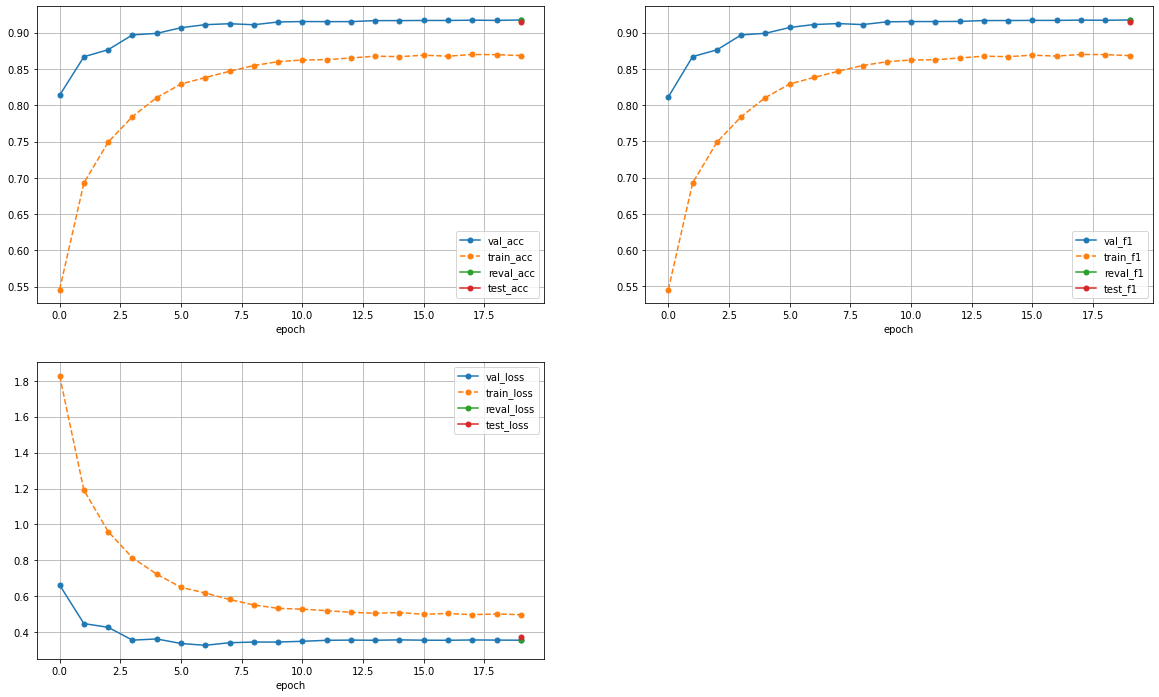

Global seed set to 16


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 16


ViT-pytorch/checkpoints/epoch=19-step=57159.ckpt


In [24]:
config = CONFIG.copy()
config["model_name"] = "R50+ViT-B_16"
best_result = runner.run_single_trial(
    VitAlternativeClassifier,
    config,
    EXTRA_CONFIG,
    extra_run_name_prefix=config["model_name"] + "-",
)
show_best_checkpoint_path(best_result)

### Fine-tuning the standard ViT-B_16

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Global seed set to 16
Global seed set to 16

  | Name              | Type                           | Params
---------------------------------------------------------------------
0 | model             | VisionTransformerSkipAttOutput | 86.5 M
1 | criterion         | CrossEntropyLoss               | 0     
2 | train_metric_calc | LitMetricsCalc                 | 0     
3 | val_metric_calc   | LitMetricsCalc                 | 0     
4 | test_metric_calc  | LitMetricsCalc                 | 0     
---------------------------------------------------------------------
86.5 M    Trainable params
0         Non-trainable params
86.5 M    Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

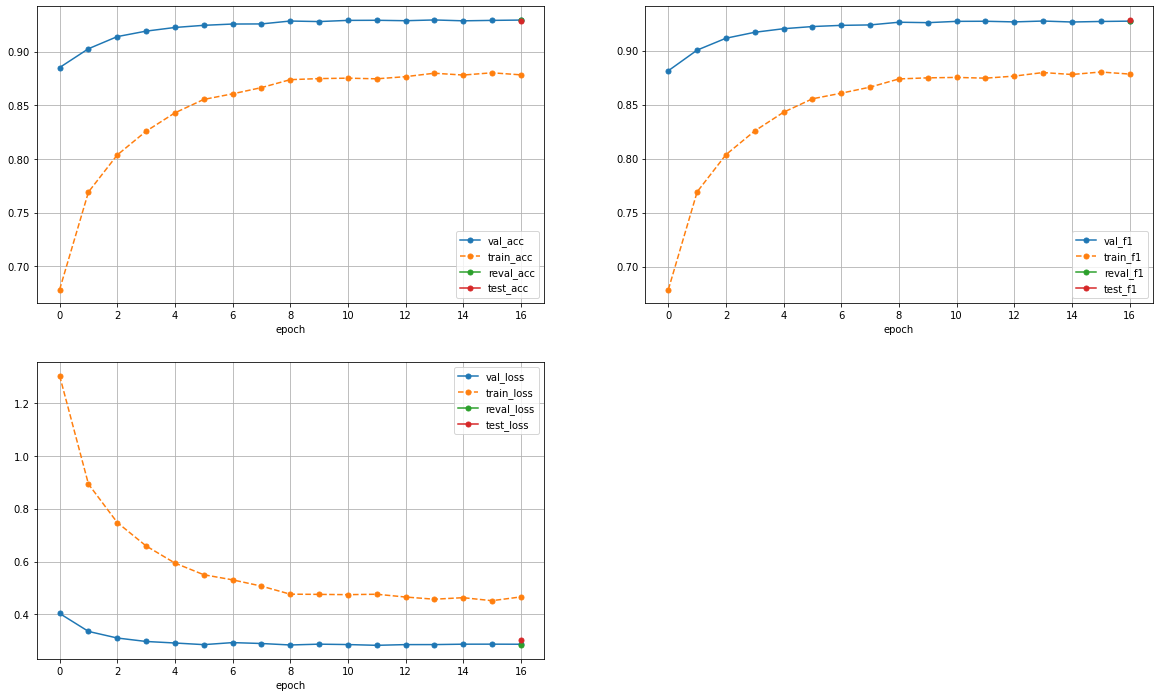

Global seed set to 16


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 16


ViT-pytorch/checkpoints/epoch=13-step=40011.ckpt


In [25]:
config = CONFIG.copy()
config["model_name"] = "ViT-B_16"
best_result = runner.run_single_trial(
    VitAlternativeClassifier,
    config,
    EXTRA_CONFIG,
    extra_run_name_prefix=config["model_name"] + "-",
)
show_best_checkpoint_path(best_result)

,test_f1,test_acc,run
18,0.9285,0.9284,ViT-B_16-single-trial-VitAlternativeClassifier
21,0.9149,0.9148,R50+ViT-B_16-single-trial-VitAlternativeClassi...


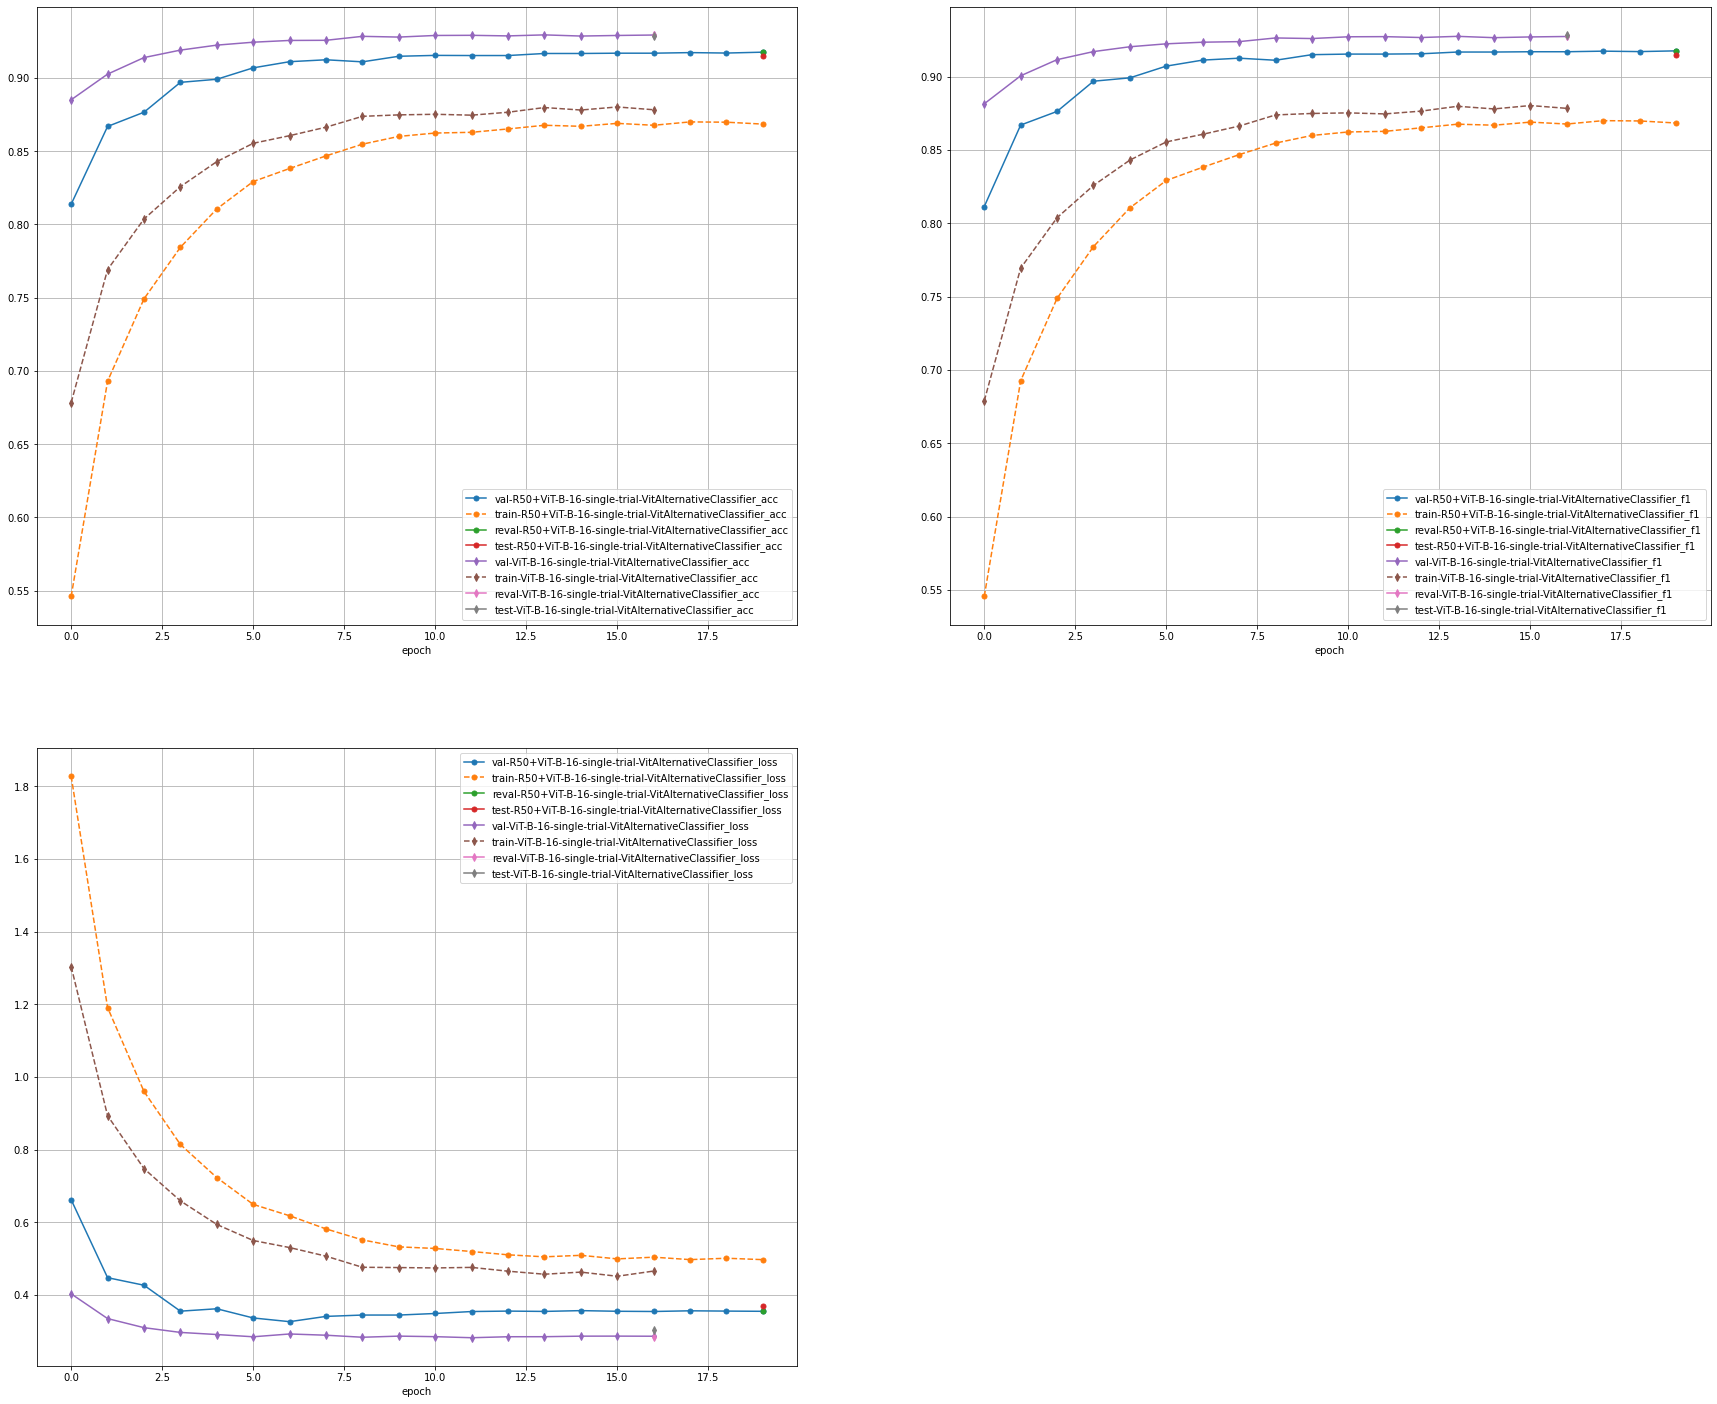

In [26]:
runner.show_metric_report(sort_by_metric_list=["test_f1", "test_acc"], figsize=(30, 25))

### Hybrid ViT vs standard ViT: conclusion

Hybrid ViT (R50+ViT-B_16)
1. converges slower in terms of model accuracy and f1 metric;
2. requires more FLOPS for both the forward and backward passes which results in ~ 2 times longer wall clock time for a single epoch comparing to the standard ViT-B_16;
3. doesn't seem to give any advantages for fine-tuning on CIFAR100 over the standard ViT-B_16 of the same size given we load the pretrained weights from Google's [vision-transformer](https://github.com/google-research/vision_transformer) Github repository.
4. achieves lower precision than the standard ViT-B_16 after the same number of epochs.

The fine-tuning experiments run by the author of [ViT-pytorch](https://github.com/jeonsworld/ViT-pytorch#imagenet-21k) GitHub repo show that R50+ViT-B_16 can achive the same precision on CIFAR100 as ViT-B_16 given enough training time and careful hyper-parameter fine-tuning. The goal of our experiment, however, is to compare two transformers under the same settings and we can safely conclude that the hybrid R50+ViT-B_16 doesn't have any advantages over standard ViT-B_16, given that both models use the weights pretrained on ImageNet21k. On the opposite, the satandard ViT-B_16 works faster and achives the target precision also faster. In our opinion, ViT-B_16 is preferrable over R50+ViT-B_16 for the transfer learning tasks (i.e. when we deal with fine-tuning already pre-trained models).

The advantages that the standard ViT shows in fine-tuning can quickly dissapear when the model is trained from the ground up (pre-training) on ImageNet21k. As shown by the authors of [[2]](#2) the hybrid ViTs have advantages over standard ViTs for pre-training for smaller computational budgets (meaning smaller model sizes and datasets). This advantage, however, dissapears for larger models as standard ViTs can use its attentiona heads to imitate the convolutional layers that present in the hybrid ViTs out of the box. But this consideration doesn't apply to our case of fine-tuning on CIFAR100 because we deal with already pretrained models where the hybrid R50-ViT-B_16 failed to show any advantages.

## References

[1] "Attention Is All You Need", Ashish Vaswani and Noam Shazeer and Niki Parmar and Jakob Uszkoreit and Llion Jones and Aidan N. Gomez and Lukasz Kaiser and Illia Polosukhin,
      2017,
      [arXiv/1706.03762](https://arxiv.org/abs/1706.03762)
    
[2]. "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale", Alexey Dosovitskiy and Lucas Beyer and Alexander Kolesnikov and Dirk Weissenborn and Xiaohua Zhai and Thomas Unterthiner and Mostafa Dehghani and Matthias Minderer and Georg Heigold and Sylvain Gelly and Jakob Uszkoreit and Neil Houlsby, 2020, [arXiv/2010.11929](https://arxiv.org/abs/2010.11929)

[3] [Vision Transformer](https://github.com/google-research/vision_transformer) GitHub repo with original implementation of Vision Transformer in Jax by Google

[4] [PyTorch-Pretrained-ViT](https://github.com/lukemelas/PyTorch-Pretrained-ViT) GitHub project